<a href="https://colab.research.google.com/github/mabench-tuc/LoRA-of-LLMs/blob/main/LoRA_adapted_Gpt_2_on_E2E_NLG_with_multiple_ranks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup Installation Process

In [ ]:
#!pip install git+https://github.com/microsoft/LoRA
!pip install -qU bitsandbytes accelerate loralib transformers peft trl
!pip install "datasets<4.0.0"
! pip install -U sacrebleu evaluate rouge-score
#!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 130.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=4b83ab60d9e0dd55c05cb922a41bc923ed0694a53f151f291ed437b4b37b3751


In [ ]:
import torch
torch.cuda.is_available()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, AutoModelForSeq2SeqLM, TrainingArguments
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoModelForSequenceClassification
from datasets import load_dataset
import bitsandbytes as bnb

In [ ]:
import time
import math
import json
import torch
import numpy as np
import pandas as pd
import evaluate

## Model's Loading
Here we load the model with its weights and the tokenizer

## Load the GPT-2 Large model

In [ ]:
# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the GPT-2 Large model and tokenizer
print("Loading gpt2-large model...")
gpt2_large_model = AutoModelForCausalLM.from_pretrained("gpt2-large").to(device)

gpt2_large_tokenizer = AutoTokenizer.from_pretrained("gpt2-large")
print("Successfully loaded gpt2-large model.")

OUTPUT_DIR = "./lora_e2e_mranks_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

Loading gpt2-large model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Successfully loaded gpt2-large model.


In [ ]:
model=gpt2_large_model
tokenizer= gpt2_large_tokenizer

In [ ]:
print(model)
#print_trainable_parameters(gpt2_large_model)

## Post-processing on the model
### Freezing the original weights
We need to apply some post-processing on the n-bit model to enable training, let's freeze all our layers, and cast the layer-norm in floatm for stability.

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

###Display Trainable Parameters

In [ ]:
def print_trainable_parameters(model):

    #Prints the number of trainable parameters in the model.

    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model)

trainable params: 737280 || all params: 774767360 || trainable%: 0.09516146885692242


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1803: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## Load E2E NLG Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("GEM/e2e_nlg")

# Add padding token for GPT-2
tokenizer.pad_token = tokenizer.eos_token

# Tokenize (dynamic padding instead of fixed 512)
tokenized_datasets = dataset.map(
    lambda x: tokenizer(x["meaning_representation"], truncation=True, padding="longest"),
    batched=True
)
# Display an example of the tokenized dataset
print(tokenized_datasets["train"][0])

README.md: 0.00B [00:00, ?B/s]

e2e_nlg.py: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

The repository for GEM/e2e_nlg contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/GEM/e2e_nlg.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/33525 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1484 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1847 [00:00<?, ? examples/s]

Generating challenge_train_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_validation_sample split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating challenge_test_scramble split:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/33525 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'gem_id': 'e2e_nlg-train-0', 'gem_parent_id': 'e2e_nlg-train-0', 'meaning_representation': 'name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]', 'target': 'The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.', 'references': [], 'input_ids': [3672, 58, 464, 18456, 4357, 4483, 6030, 58, 1073, 5853, 6128, 4357, 2057, 58, 25324, 4357, 2756, 17257, 58, 1203, 621, 4248, 1238, 4357, 6491, 7955, 58, 9319, 4357, 1989, 58, 380, 690, 485, 4357, 1641, 23331, 306, 58, 8505, 4357, 1474, 58, 22991, 1362, 2677, 60, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [ ]:
tokenized_datasets.keys()

dict_keys(['train', 'validation', 'test', 'challenge_train_sample', 'challenge_validation_sample', 'challenge_test_scramble'])

###Tokenization of the dataset

In [ ]:
# GPT-2-specific settings: Add padding tokens, as GPT-2 does not use padding by default
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 uses <|endoftext|> as a padding token

# Step 3: Define the tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["meaning_representation"],           # The "data" column contains the text in the E2E NLG dataset
        max_length=512,             # Max sequence length for GPT-2
        truncation=True,            # Truncate sequences longer than 512 tokens
        padding="max_length"        # Pad sequences shorter than 512 tokens
    )

# Step 4: Tokenize the dataset
tokenized_e2e_dataset = dataset.map(tokenize_function, batched=True)

# Step 5: Display an example of the tokenized dataset
print(tokenized_e2e_dataset["train"][0])

Map:   0%|          | 0/33525 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

{'gem_id': 'e2e_nlg-train-0', 'gem_parent_id': 'e2e_nlg-train-0', 'meaning_representation': 'name[The Eagle], eatType[coffee shop], food[Japanese], priceRange[less than £20], customer rating[low], area[riverside], familyFriendly[yes], near[Burger King]', 'target': 'The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.', 'references': [], 'input_ids': [3672, 58, 464, 18456, 4357, 4483, 6030, 58, 1073, 5853, 6128, 4357, 2057, 58, 25324, 4357, 2756, 17257, 58, 1203, 621, 4248, 1238, 4357, 6491, 7955, 58, 9319, 4357, 1989, 58, 380, 690, 485, 4357, 1641, 23331, 306, 58, 8505, 4357, 1474, 58, 22991, 1362, 2677, 60, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [ ]:
#tokenized_dataset= tokenized_e2e_dataset
tokenized_dataset= tokenized_datasets
#tokenized_e2e_dataset.keys()

In [ ]:
# See available splits
print(dataset)

# Print the column headers for the training split
print("Column headers:", dataset["train"].column_names)

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 33525
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1484
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1847
    })
    challenge_train_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
    challenge_validation_sample: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
    challenge_test_scramble: Dataset({
        features: ['gem_id', 'gem_parent_id', 'meaning_representation', 'target', 'references'],
        num_rows: 500
    })
})
Column headers: ['gem_id', 'gem_pare

We create a smaller subset of the full dataset to fine-tune our model

In [ ]:
train_data= tokenized_dataset["train"].shuffle(seed=42).select(range(10000))
val_data= tokenized_dataset["validation"].shuffle(seed=42).select(range(1000))
eval_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

##Training Process

In [ ]:
#Import the necessary modules from the transformers library
import transformers
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from trl import SFTTrainer
import evaluate
from rouge_score import rouge_scorer

###Train LoRA Adapter

In [ ]:
# filepath: experiments/lora_rank_sweep_eval.py

"""
Run a LoRA rank sweep, train each model, evaluate with BLEU + ROUGE, and save CSV:
Columns: rank, # of trainable parameters, bleu, rouge1, rouge2, rougeL
Assumptions:
 - `train_data`, `val_data`, `tokenized_dataset["validation"]`, and `tokenizer` exist in the environment.
 - required packages: torch, transformers, datasets, peft, accelerate (optional), nltk, rouge_score, pandas
"""

from typing import Tuple, Dict, List
import torch
import pandas as pd
from tqdm import tqdm

from transformers import AutoModelForCausalLM, TrainingArguments
# If using SFTTrainer from trl or a custom package, adapt import accordingly:
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ---- USER VARIABLES / PREPARATION ----
# Ensure these variables are present in your environment:
# tokenizer, train_data, val_data, tokenized_dataset
# If not present, load/create them before running this script.

# This script expects the datasets to be huggingface datasets or lists of dicts with keys:
# For evaluation dataset: each item must have "input_text" and "target_text"


def preprocess_data(example):
    """Maps existing dataset columns to 'input_text' and 'target_text'."""
    # Assuming the tokenized dataset has 'meaning_representation' and 'target' columns
    return {
        "input_text": example["meaning_representation"],
        "target_text": example["target"], # Assuming 'target' is the correct column name for human reference
    }

# Create processed_data from the tokenized dataset splits
processed_data = {}
# Assuming 'tokenized_dataset' is a DatasetDict with 'validation' and 'test' splits
processed_data["validation"] = tokenized_dataset["validation"].map(preprocess_data)
processed_data["test"] = tokenized_dataset["test"].map(preprocess_data)


# ---- EVALUATION FUNCTION ----
def evaluate_model(model, tokenizer, dataset, device: str = None, max_gen_len: int = 100) -> Tuple[float, Dict[str, float]]:
    """
    Given a causal LM (model) and tokenizer, iterate dataset of dicts with keys:
    'input_text' and 'target_text', generate predictions, compute average BLEU and ROUGE scores.
    Returns: (avg_bleu, avg_rouge_dict)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    smoothing = SmoothingFunction().method1
    bleu_scores: List[float] = []
    rouge_scores_list: List[Dict[str, float]] = []

    rouge_scorer_instance = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    # If dataset is a Dataset object, iterate with .select or plain iteration works
    for example in tqdm(dataset, desc="Evaluating", leave=False):
        input_text = example["input_text"]
        target_text = example["target_text"]

        # Tokenize input for generation
        enc = tokenizer(
            input_text,
            truncation=True,
            padding=True,
            return_tensors="pt",
            max_length=512
        )
        input_ids = enc.input_ids.to(device)
        attention_mask = enc.attention_mask.to(device) if hasattr(enc, "attention_mask") else None

        with torch.no_grad():
            gen_kwargs = {"max_new_tokens": max_gen_len, "num_beams": 5, "early_stopping": True, "pad_token_id": tokenizer.eos_token_id}
            if attention_mask is not None:
                output_ids = model.generate(input_ids, attention_mask=attention_mask, **gen_kwargs)
            else:
                output_ids = model.generate(input_ids, **gen_kwargs)

        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        ref = target_text.strip()

        # BLEU (sentence-level)
        try:
            bleu_score = sentence_bleu([ref.split()], prediction.split(), smoothing_function=smoothing)
        except Exception:
            bleu_score = 0.0
        bleu_scores.append(bleu_score)

        # ROUGE
        rouge = rouge_scorer_instance.score(ref, prediction)
        rouge_scores_list.append({
            "rouge1": rouge["rouge1"].fmeasure,
            "rouge2": rouge["rouge2"].fmeasure,
            "rougeL": rouge["rougeL"].fmeasure,
        })

    # Avoid division by zero
    n = max(1, len(bleu_scores))
    avg_bleu = sum(bleu_scores) / n
    avg_rouge = {
        "rouge1": sum(r["rouge1"] for r in rouge_scores_list) / max(1, len(rouge_scores_list)),
        "rouge2": sum(r["rouge2"] for r in rouge_scores_list) / max(1, len(rouge_scores_list)),
        "rougeL": sum(r["rougeL"] for r in rouge_scores_list) / max(1, len(rouge_scores_list)),
    }

    return avg_bleu, avg_rouge


# ---- SWEEP & TRAIN ----
def run_lora_rank_sweep(
    ranks,
    tokenizer,
    train_data,
    val_data,
    processed_validation_dataset,
    output_csv: str = "lora_rank_results.csv",
    reduce_val_size: int = 500
):
    results = []

    for r in ranks:
        print(f"\n===== Training with LoRA rank {r} =====\n")

        config = LoraConfig(
            r=r,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["attn.c_attn"],
            bias="none",
            task_type="CAUSAL_LM",
        )

        # Load fresh base model for each rank
        base_model = AutoModelForCausalLM.from_pretrained("gpt2")
        base_model.config.pad_token_id = base_model.config.eos_token_id

        lora_model = get_peft_model(base_model, config)

        # Training args — adjust as needed
        training_args = TrainingArguments(
            output_dir=f"./results/rank_{r}",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=2e-4,
            lr_scheduler_type="linear",
            warmup_steps=500,
            num_train_epochs=5,
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=4,
            gradient_checkpointing=True,
            fp16=torch.cuda.is_available(),
            dataloader_pin_memory=True,
            weight_decay=0.01,
            logging_dir="./logs_lorarank_gpt2",
            logging_strategy="steps",
            logging_steps=20,
            save_total_limit=2,
            load_best_model_at_end=True,
            report_to="none",
            optim="adamw_torch",
        )

        # Prepare train/val tokenized datasets for SFTTrainer expected format:
        # create labels column for causal LM training (copy of input_ids)
        train_with_labels = train_data.add_column("labels", train_data["input_ids"])
        val_small = val_data.select(range(min(reduce_val_size, len(val_data))))
        val_with_labels = val_small.add_column("labels", val_small["input_ids"])

        # If SFTTrainer is available, use it. If not, adapt to trainer class.
        try:
            trainer = SFTTrainer(
                model=lora_model,
                args=training_args,
                train_dataset=train_with_labels,
                eval_dataset=val_with_labels,
                compute_metrics=None,  # we'll compute BLEU/ROUGE separately below
            )

            trainer.train()
            # trainer.evaluate() can be left or used; we will compute BLEU/ROUGE using our evaluator for consistency.
            _ = trainer.evaluate()
        except NameError:
            # If SFTTrainer is not available, skip training (or integrate your own trainer here)
            print("SFTTrainer not found in this environment. Skipping trainer.train().")
        except Exception as e:
            print(f"Trainer failed with exception: {e}. Attempting to continue to evaluation.")

        # Count trainable parameters
        trainable_count = int(sum(p.numel() for p in lora_model.parameters() if p.requires_grad))

        # Evaluate on processed_validation_dataset (we'll use a reduced subset for speed)
        # If processed_validation_dataset is huge, select a smaller slice:
        try:
            val_for_eval = processed_validation_dataset.select(range(min(500, len(processed_validation_dataset))))
        except Exception:
            # If .select isn't available, assume it's an iterable and slice
            val_for_eval = list(processed_validation_dataset)[:500]

        avg_bleu, avg_rouge = evaluate_model(lora_model, tokenizer, val_for_eval)

        results.append({
            "rank": r,
            "# of trainable parameters": trainable_count,
            "bleu": avg_bleu,
            "rouge1": avg_rouge["rouge1"],
            "rouge2": avg_rouge["rouge2"],
            "rougeL": avg_rouge["rougeL"],
        })

        # Cleanup
        del lora_model, base_model
        if 'trainer' in locals():
            try:
                del trainer
            except Exception:
                pass
        torch.cuda.empty_cache()

    # Save results to CSV
    df = pd.DataFrame(results, columns=["rank", "# of trainable parameters", "bleu", "rouge1", "rouge2", "rougeL"])
    df.to_csv(output_csv, index=False)
    print(f"Saved LoRA rank sweep results to {output_csv}")
    return df


# ---- MAIN EXECUTION ----
if __name__ == "__main__":
    ranks = [1, 4, 8, 16, 32]
    # Ensure the following variables are defined in your session:
    # tokenizer, train_data, val_data, processed_data["validation"]
    # If they are not, load them here.

    # Ensure processed_data is created before calling run_lora_rank_sweep
    # This block should be executed before the sweep function call
    def preprocess_data_main(example):
        """Maps existing dataset columns to 'input_text' and 'target_text' for the main block."""
        # Assuming the tokenized dataset has 'meaning_representation' and 'target' columns
        return {
            "input_text": example["meaning_representation"],
            "target_text": example["target"], # Assuming 'target' is the correct column name
        }

    # Create processed_data from the tokenized dataset splits
    # Assuming 'tokenized_dataset' is a DatasetDict with 'validation' and 'test' splits
    processed_data = {}
    processed_data["validation"] = tokenized_dataset["validation"].map(preprocess_data_main)
    processed_data["test"] = tokenized_dataset["test"].map(preprocess_data_main)


    df_results = run_lora_rank_sweep(
        ranks=ranks,
        tokenizer=tokenizer,
        train_data=train_data,
        val_data=val_data,
        processed_validation_dataset=processed_data["validation"], # Use the correctly processed dataset
        output_csv="lora_rank_results.csv",
        reduce_val_size=500,
    )

    print(df_results)

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]

Map:   0%|          | 0/1484 [00:00<?, ? examples/s]

Map:   0%|          | 0/1847 [00:00<?, ? examples/s]


===== Training with LoRA rank 1 =====



config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Flattening the indices:   0%|          | 0/10000 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncating train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.373900,0.341989,0.404631,557227.000000,0.883029
2,0.333600,0.311985,0.342624,1114454.000000,0.891365
3,0.304700,0.293974,0.273916,1671681.000000,0.902707
4,0.304100,0.286328,0.261619,2228908.000000,0.904994
5,0.290900,0.288896,0.251112,2786135.000000,0.903172



===== Training with LoRA rank 4 =====



/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.353200,0.314773,0.324997,557227.000000,0.887205
2,0.303800,0.303377,0.279288,1114454.000000,0.895633
3,0.268800,0.293788,0.255290,1671681.000000,0.903561
4,0.267400,0.285862,0.247038,2228908.000000,0.906172
5,0.251300,0.288722,0.236501,2786135.000000,0.904898



===== Training with LoRA rank 8 =====



/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.351600,0.315563,0.335680,557227.000000,0.884586
2,0.302600,0.299446,0.277808,1114454.000000,0.895667
3,0.264200,0.289403,0.248653,1671681.000000,0.905704
4,0.262500,0.282409,0.241894,2228908.000000,0.906968
5,0.247100,0.285224,0.231032,2786135.000000,0.908579



===== Training with LoRA rank 16 =====



/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.340000,0.317803,0.315855,557227.000000,0.883334
2,0.302600,0.296308,0.277063,1114454.000000,0.896082
3,0.267800,0.288153,0.252771,1671681.000000,0.903851
4,0.261700,0.285126,0.243854,2228908.000000,0.908571
5,0.247000,0.286876,0.234420,2786135.000000,0.908717



===== Training with LoRA rank 32 =====



/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': None}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.344500,0.319724,0.325131,557227.000000,0.881847
2,0.303900,0.300832,0.273702,1114454.000000,0.899782
3,0.271900,0.287846,0.255830,1671681.000000,0.903226
4,0.265500,0.285549,0.245605,2228908.000000,0.907471
5,0.253100,0.290197,0.236087,2786135.000000,0.906971


Saved LoRA rank sweep results to lora_rank_results.csv
   rank  # of trainable parameters      bleu    rouge1  rouge2    rougeL
0     1                      36864  0.006104  0.516303   0.202  0.349177
1     4                     147456  0.006104  0.516289   0.202  0.349163
2     8                     294912  0.006104  0.516311   0.202  0.349184
3    16                     589824  0.006104  0.516424   0.202  0.349177
4    32                    1179648  0.006104  0.516436   0.202  0.349184


##GPU Check

In [ ]:
!nvidia-smi

Thu Sep 25 02:55:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   36C    P0             58W /  400W |    4741MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Visualizations of LoRA Adaptation of GPT-2 on E2E NLG

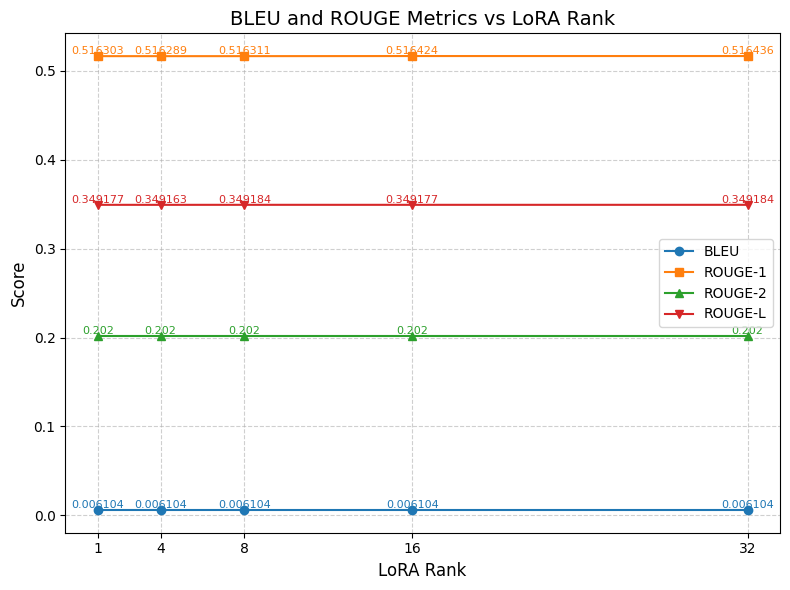

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results file (adjust path if needed)
df = pd.read_csv("lora_rank_results.csv")

plt.figure(figsize=(8,6))

# Plot all metrics
plt.plot(df['rank'], df['bleu'], marker='o', color='C0', label='BLEU')
plt.plot(df['rank'], df['rouge1'], marker='s', color='C1', label='ROUGE-1')
plt.plot(df['rank'], df['rouge2'], marker='^', color='C2', label='ROUGE-2')
plt.plot(df['rank'], df['rougeL'], marker='v', color='C3', label='ROUGE-L')

# Annotate each point with six decimal values
for i, r in enumerate(df['rank']):
    plt.text(r, df['bleu'][i], f"{df['bleu'][i]:.6f}", ha='center', va='bottom', fontsize=8, color='C0')
    plt.text(r, df['rouge1'][i], f"{df['rouge1'][i]:.6f}", ha='center', va='bottom', fontsize=8, color='C1')
    plt.text(r, df['rouge2'][i], f"{df['rouge2'][i]:.3f}", ha='center', va='bottom', fontsize=8, color='C2')
    plt.text(r, df['rougeL'][i], f"{df['rougeL'][i]:.6f}", ha='center', va='bottom', fontsize=8, color='C3')

# Labels and formatting
plt.xlabel("LoRA Rank", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("BLEU and ROUGE Metrics vs LoRA Rank", fontsize=14)
plt.xticks(df['rank'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("bleu_rouge_vs_lora_ranks.png", dpi=300)
plt.show()


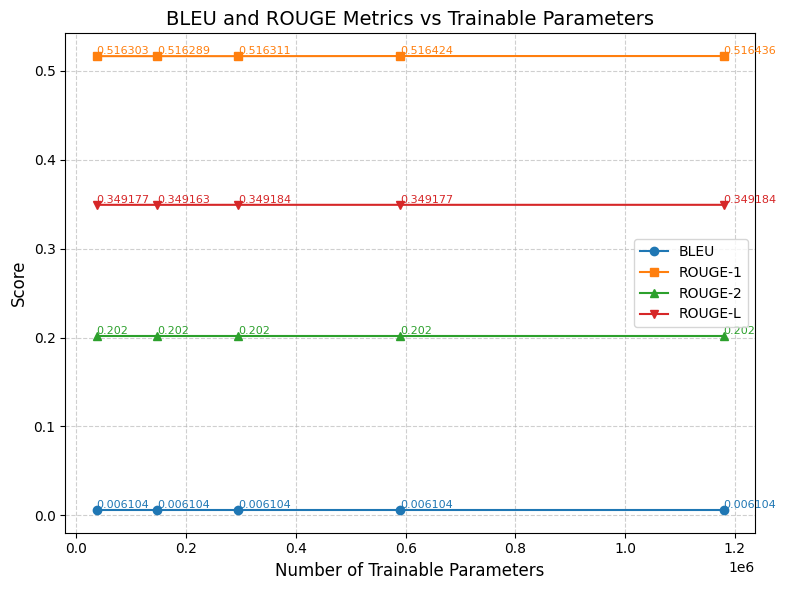

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))

# Plot each metric
plt.plot(df['# of trainable parameters'], df['bleu'], marker='o', label='BLEU', color='C0')
plt.plot(df['# of trainable parameters'], df['rouge1'], marker='s', label='ROUGE-1', color='C1')
plt.plot(df['# of trainable parameters'], df['rouge2'], marker='^', label='ROUGE-2', color='C2')
plt.plot(df['# of trainable parameters'], df['rougeL'], marker='v', label='ROUGE-L', color='C3')

# Annotate each point with six decimal places
for i, row in df.iterrows():
    plt.text(row['# of trainable parameters'], row['bleu'], f"{row['bleu']:.6f}", fontsize=8, color='C0', ha='left', va='bottom')
    plt.text(row['# of trainable parameters'], row['rouge1'], f"{row['rouge1']:.6f}", fontsize=8, color='C1', ha='left', va='bottom')
    plt.text(row['# of trainable parameters'], row['rouge2'], f"{row['rouge2']:.3f}", fontsize=8, color='C2', ha='left', va='bottom')
    plt.text(row['# of trainable parameters'], row['rougeL'], f"{row['rougeL']:.6f}", fontsize=8, color='C3', ha='left', va='bottom')

# Formatting
plt.xlabel("Number of Trainable Parameters", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("BLEU and ROUGE Metrics vs Trainable Parameters", fontsize=14)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save figure
plt.savefig("combined_bleu_rouge_vs_params.png", dpi=300)
plt.show()


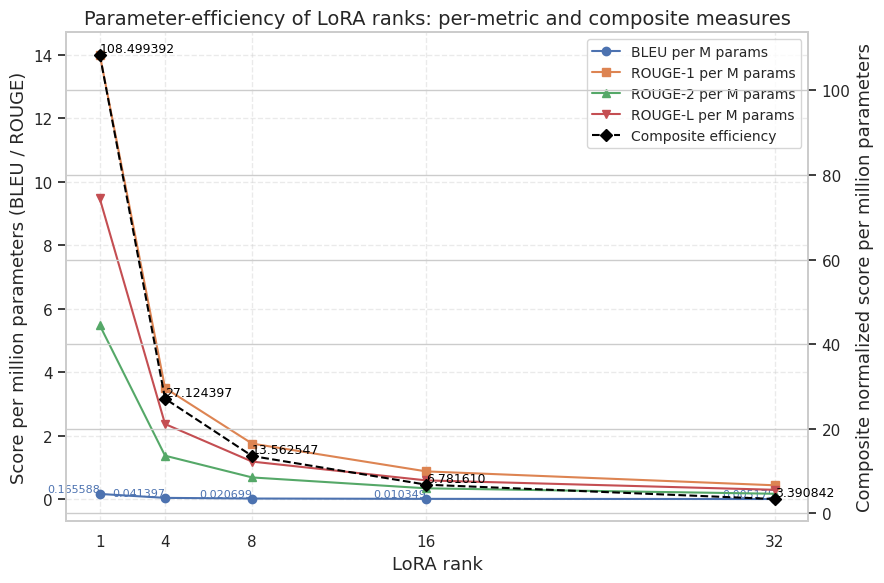

Rank | params (M) | eff_bleu | eff_rougeL | eff_composite
   1 | 0.037 M | 0.165588 | 9.472023 | 108.499392
   4 | 0.147 M | 0.041397 | 2.367912 | 27.124397
   8 | 0.295 M | 0.020699 | 1.184029 | 13.562547
  16 | 0.590 M | 0.010349 | 0.592001 | 6.781610
  32 | 1.180 M | 0.005175 | 0.296007 | 3.390842


In [ ]:
# Metric efficiency vs LoRA rank: BLEU/ROUGE per million params + composite efficiency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 12})

fn = "lora_rank_results.csv"
df = pd.read_csv(fn)

# --- required columns check ---
req = ["rank", "# of trainable parameters", "bleu", "rouge1", "rouge2", "rougeL"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in {fn}: {missing}. Rename them or update the CSV.")

# --- prepare quantities ---
df = df.copy()
df["params_million"] = df["# of trainable parameters"].astype(float) / 1e6
# avoid division by zero
if (df["params_million"] <= 0).any():
    raise ValueError("Found non-positive values in '# of trainable parameters'")

# efficiencies: score per million parameters
df["eff_bleu"]   = df["bleu"].astype(float)   / df["params_million"]
df["eff_rouge1"] = df["rouge1"].astype(float) / df["params_million"]
df["eff_rouge2"] = df["rouge2"].astype(float) / df["params_million"]
df["eff_rougeL"] = df["rougeL"].astype(float) / df["params_million"]

# composite efficiency: normalize each metric by its max across ranks (range 0..1), sum, then divide by params_million
eps = 1e-12
norm_bleu   = df["bleu"].astype(float)   / (df["bleu"].astype(float).max()   + eps)
norm_r1     = df["rouge1"].astype(float) / (df["rouge1"].astype(float).max() + eps)
norm_r2     = df["rouge2"].astype(float) / (df["rouge2"].astype(float).max() + eps)
norm_rL     = df["rougeL"].astype(float) / (df["rougeL"].astype(float).max() + eps)
df["composite_norm"] = norm_bleu + norm_r1 + norm_r2 + norm_rL   # range ~0..4
df["eff_composite"] = df["composite_norm"] / df["params_million"]

# sort by rank for plotting
df.sort_values(by="rank", inplace=True)
ranks = df["rank"].values

# --- plotting ---
fig, ax = plt.subplots(figsize=(9,6))

# plot individual efficiencies
ax.plot(ranks, df["eff_bleu"],   marker='o', linestyle='-', label='BLEU per M params',   zorder=4)
ax.plot(ranks, df["eff_rouge1"], marker='s', linestyle='-', label='ROUGE-1 per M params', zorder=4)
ax.plot(ranks, df["eff_rouge2"], marker='^', linestyle='-', label='ROUGE-2 per M params', zorder=4)
ax.plot(ranks, df["eff_rougeL"], marker='v', linestyle='-', label='ROUGE-L per M params', zorder=4)

# plot composite efficiency on secondary axis (keeps scale readable)
ax2 = ax.twinx()
ax2.plot(ranks, df["eff_composite"], marker='D', linestyle='--', color='black', label='Composite efficiency', zorder=5)

# annotate each point with six decimal places (main metrics)
for i, r in enumerate(ranks):
    x = r
    # annotate the composite on the right axis with 6 decimals
    ax2.text(x, df["eff_composite"].iloc[i], f"{df['eff_composite'].iloc[i]:.6f}",
             fontsize=9, ha='left', va='bottom', color='black')
    # small annotations for BLEU (example) — avoid overcrowding by offsetting slightly
    ax.text(x, df["eff_bleu"].iloc[i], f"{df['eff_bleu'].iloc[i]:.6f}",
            fontsize=8, ha='right', va='bottom', color=ax.get_lines()[0].get_color())

# axis labels, title, ticks
ax.set_xlabel("LoRA rank", fontsize=13)
ax.set_ylabel("Score per million parameters (BLEU / ROUGE)", fontsize=13)
ax2.set_ylabel("Composite normalized score per million parameters", fontsize=13)
ax.set_title("Parameter-efficiency of LoRA ranks: per-metric and composite measures", fontsize=14)

ax.set_xticks(ranks)
ax.grid(True, linestyle='--', alpha=0.4)

# legends: combine handles from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1 + h2, l1 + l2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig("efficiency_vs_rank.png", dpi=300)
plt.show()

# --- brief printed summary for thesis reporting ---
print("Rank | params (M) | eff_bleu | eff_rougeL | eff_composite")
for _, row in df.iterrows():
    print(f"{int(row['rank']):>4} | {row['params_million']:.3f} M | "
          f"{row['eff_bleu']:.6f} | {row['eff_rougeL']:.6f} | {row['eff_composite']:.6f}")


##Inference for NLG Tasks

In [ ]:
# Load the tokenizer and model
tokenizergpt2 = GPT2Tokenizer.from_pretrained("gpt2")
# Load the tokenizer and model

modelgpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer=tokenizergpt2
model= modelgpt2

In [ ]:
# Prompt
prompt = "Once upon a time"
#prompt= "Write a Python function to check if a number is prime."

# Tokenize the input text
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[7454, 2402,  257,  640]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
# Generate text
output_ids = model.generate(
    inputs.input_ids.to(model.device),
    attention_mask=inputs.attention_mask.to(model.device),
    pad_token_id=tokenizer.eos_token_id,
    max_length=50,
    num_return_sequences=1
)

output_ids

tensor([[7454, 2402,  257,  640,   11,  262,  995,  373, 9086,  656,  734, 3354,
           25,  262, 2258,  290,  262, 2520,   13,  383, 2258,  373, 8879,  416,
          262, 5822,  286,  262, 2258,   11,  290,  262, 2520,  373, 8879,  416,
          262, 5822,  286,  262, 2520,   13,  383, 5822,  286,  262, 2258,  373,
         1444,  262]], device='cuda:0')

In [ ]:
# Decode the generated text
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(generated_text)

Once upon a time, the world was divided into two parts: the North and the South. The North was ruled by the king of the North, and the South was ruled by the king of the South. The king of the North was called the
